# Einstiegsbeispiel: Espresso in Keramik- und Isolationstasse

Das folgende Beispiel illustriert wesentliche Inhalte dieses Moduls, es wird daher **nicht** erwartet, dass Sie die Begriffe verstehen.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from netgen.occ import WorkPlane, OCCGeometry, X, Y, Z, Glue, Compound
from ngsolve import *
from netgen.webgui import Draw as DrawShape
from ngsolve.webgui import Draw

## Geometrie und Mesh

Wir definieren die Geometrie der Tasse, Flüssigkeit und Umgebung mit Hilfe des Open Cascade Technology (OCCT) Geometry Kernels.

In [3]:
wp = WorkPlane()
sPnts = [(0.024, 0.008),
         (0.028, 0.016),
         (0.032, 0.04),
         (0.022, 0.02),
         (0.004, 0.006),
         (-0.004, 0.006),
         (-0.022, 0.02),
         (-0.032, 0.04),
         (-0.028, 0.016),
         (-0.024, 0.008),
         (-0.016, 0)]
wp.MoveTo(4*4e-3,0).Spline(sPnts)
face = wp.Close().Face()

Das Innere ist durch die Orientierung des Randes gegeben. Setzen wir uns auf den Rand, so ist auf der linken Seite das Innere und auf der rechten das Äussere. Daher ist hier die Geometrie in positiver mathematischer Orientierung definiert.

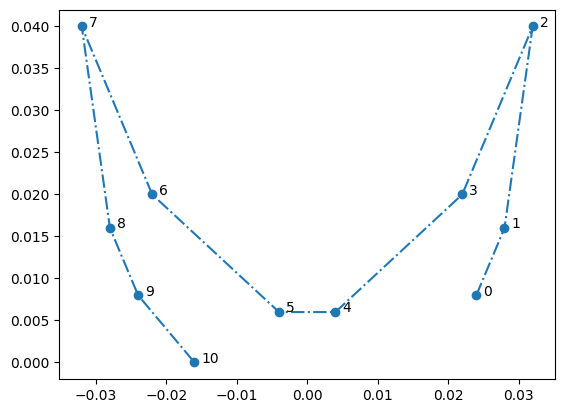

In [4]:
p = np.array(sPnts)
plt.plot(p[:,0],p[:,1],'o-.')
for i,pi in enumerate(p):
    plt.text(*(np.array(pi)+np.array([0.001,0])),str(i))
plt.show()

Damit erhalten wir die Tasse ohne Vakuum Bereich:

In [5]:
DrawShape(face)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'ngsolve_version': 'Netgen x.x', 'mesh_dim': 3…

BaseWebGuiScene

Den inneren Vakuum Bereich definieren wir analog:

In [6]:
wp2 = WorkPlane()
sPnts2 = [(0.0224, 0.008),
          (0.0264, 0.016),
          (0.0312, 0.036),
          (0.022, 0.0184),
          (0.004, 0.0048),
          (-0.004, 0.0048),
          (-0.022, 0.0184),
          (-0.0312, 0.036),
          (-0.0264, 0.016),
          (-0.0224, 0.008),
          (-0.0152, 0.0012)]
wp2.MoveTo(4*3.8e-3,4*.3e-3).Spline(sPnts2)
isolator = wp2.Close().Face()

In [7]:
DrawShape(isolator)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'ngsolve_version': 'Netgen x.x', 'mesh_dim': 3…

BaseWebGuiScene

Das Glas ist daher gegeben durch die Boolsche Operaton `face - isolator`:

In [8]:
glas = face-isolator

In [9]:
DrawShape(glas)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'ngsolve_version': 'Netgen x.x', 'mesh_dim': 3…

BaseWebGuiScene

Die Flüssigkeit wird ähnlich aufgebaut. Wir definieren ein Trapez und subtrahieren die Fläche der Tasse:

In [10]:
wp3 = WorkPlane()
wp3.MoveTo(-4*3.9e-3,2*1.5e-3).LineTo(4*3.9e-3,2*1.5e-3).LineTo(4*7.2e-3,3*9.5e-3).LineTo(-4*7.2e-3,3*9.5e-3)
face3 = wp3.Close().Face()
liquid = face3-face

In [11]:
DrawShape(liquid)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'ngsolve_version': 'Netgen x.x', 'mesh_dim': 3…

BaseWebGuiScene

Die Luft wird entsprechend analog definiert:

In [12]:
wp4 = WorkPlane()
wp4.MoveTo(-.2,0).LineTo(.2,0).LineTo(.2,.25).LineTo(-.2,.25)
box = wp4.Close().Face()
air = box-face-face3

In [13]:
DrawShape(air)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'ngsolve_version': 'Netgen x.x', 'mesh_dim': 3…

BaseWebGuiScene

Alles zusammen geklebt `glue` liefert unser Modell. Um später die einzelnen Teilflächen / Gebiete mit verschiedenen Materialparameter versehen zu können definieren wir Namen. Ebenso können wir Ränder bezeichnen und die Feinheit des Meshes beeinflussen:

In [14]:
air.faces.name = 'air'
glas.faces.name = 'glas'
isolator.faces.name = 'isolator'
liquid.faces.name = 'liquid'

air.maxh = 30e-3
isolator.maxh = 5e-3
glas.maxh = 5e-4
liquid.maxh = 2.5e-3

glas.edges.Min(Y).name='bottom'
air.edges.Min(X).name='outer'
air.edges.Max(X).name='outer'
air.edges.Max(Z).name='outer'
air.edges.Max(Y).name='outer'
air.edges.Nearest((-.1,0)).name='bottom'
air.edges.Nearest((.1,0)).name='bottom'

model = Glue([air, glas, isolator, liquid])

DrawShape(model)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'ngsolve_version': 'Netgen x.x', 'mesh_dim': 3…

BaseWebGuiScene

Damit erhalten wir die Geometrie und das Mesh für unser Modell.

In [15]:
geo = OCCGeometry(model, dim=2) # wichtig: dim=2 muss hier zwingend definiert werden!
mesh = Mesh(geo.GenerateMesh())
mesh.Curve(2)

In [16]:
mesh.GetMaterials()

('air', 'glas', 'isolator', 'liquid')

In [17]:
Draw(mesh)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

BaseWebGuiScene

## Stationäre Wärmeleitung

Die stationäre Wärmeverteilung kann mit Hilfe der Poisson-Gleichung modelliert werden. Es wird dabei vorausgesetzt, dass die Wärme sich diffusiv im Raum verteilt. Dabei wird die Wärmeleitung unterschiedlich, also vom Ort abhängig. Womit wir unterschiedliche Objekte im Raum berücksichtigen können.

Wir betrachten daher das Problem bzw. die partielle Differentialgleichung

$$\mathop{div} \lambda(x) \nabla T = q\quad \text{für}\ x\in\Omega$$

mit der Bedingung, dass $T=20$ auf dem unteren Rand (z.B. Tisch) gilt, folgt ein Randwertproblem. Die Lösung dieses Randwertproblems suchen wir in einem geeigneten Funktionenraum, welchen wir wiederum mit Hilfe von finiter Elemente diskretisieren.

In [18]:
order = 3
V = H1(mesh,order = order, dirichlet = 'bottom')
u,v = V.TnT()

Damit haben wir das unendlichdimensionale Problem auf ein endlich dimensionales reduziert.

In [19]:
V.ndof

36169

Ortsabhängige Wärmeleitfähigkeit

In [20]:
lam_mat = {'glas': 20, 'isolator': 20, 'liquid': 0.597, 'air': 0.0262}
lam = CoefficientFunction([lam_mat[mat] for mat in mesh.GetMaterials()])

In [21]:
a = BilinearForm(V,symmetric=True)
a += lam*grad(u)*grad(v)*dx
a.Assemble()

In [22]:
lam_mat2 = {'glas': 20, 'isolator': 0.0262, 'liquid': 0.597, 'air': 0.0262}
lam2 = CoefficientFunction([lam_mat2[mat] for mat in mesh.GetMaterials()])

In [23]:
a2 = BilinearForm(V,symmetric=True)
a2 += lam2*grad(u)*grad(v)*dx
a2.Assemble()

## Kaffee als Wärmequelle

Den warmen Kaffee betrachten wir als Wärmequelle, was natürlich nicht korrekt ist. Das macht uns aber in der Modellierung das Leben bedeutend einfacher. Den Einfluss der Tasse kann trotzdem sehr gut beobachtet werden.,

In [24]:
f = LinearForm(V)
f += CoefficientFunction(6e4)*v*dx('liquid')
f.Assemble()

Zudem betrachten wir nun nur die relative Temperaturänderung zu einer konstanten Umgebungstemperatur. Für die numerischen Lösungen gibt es in `ngsolve` sogenannte `GridFunction`'s.

In [25]:
gfu = GridFunction(V)
gfu2 = GridFunction(V)

In [26]:
gfu.vec.data += a.mat.Inverse(freedofs=V.FreeDofs())*f.vec
gfu2.vec.data += a2.mat.Inverse(freedofs=V.FreeDofs())*f.vec

In [27]:
Draw(gfu,min=0,max=60)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

BaseWebGuiScene

In [28]:
Draw(gfu2,min=0,max=60)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

BaseWebGuiScene